# Exercise: Nonlinear Programming¶

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from casadi import (
    DM, MX, Function, 
    vertcat, horzcat,
    gradient, hessian, jacobian,
    inf, tanh, sin, cos,
    conic
)


In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Problem

\begin{aligned}
\min_x & \quad & x_1^2 + \tanh(x_2)^2 \\
\text{subject to} & \quad & \cos(x_1 + x_2) = 0 \\
                  & \quad & \sin(x_1) + 0.5 \le 0 \\
\end{aligned}

with $x \in \mathbb{R}^2$.

In [3]:
x1 = 0.
x2 = np.arccos(-0.5) - x1
x2

2.0943951023931957

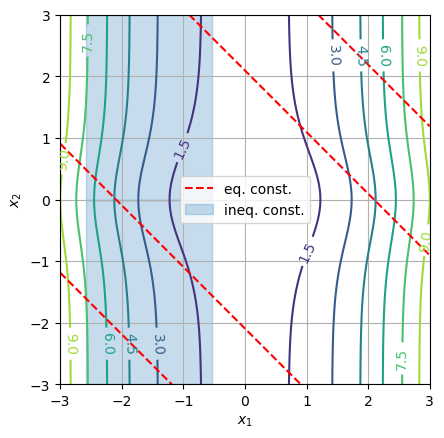

In [4]:
def plot_countours(x1_lim=(-3, 3), x2_lim=(-3, 3)):
    x1_range = np.linspace(x1_lim[0], x1_lim[1], 101)
    x2_range = np.linspace(x2_lim[0], x2_lim[1], 101)
    x1, x2 = np.meshgrid(x1_range, x2_range)
    f = x1**2 + tanh(x2) ** 2
    x2_eq_consts1 = [np.arccos(-0.5) - x1_range + i*2*np.pi for i in range(-1, 2)]
    x2_eq_consts2 = [-np.arccos(-0.5) - x1_range + i*2*np.pi for i in range(-1, 2)]
    x1_ineq_const = np.sin(x1_range) <= -0.5
    fill_areas_pos = np.where(x1_ineq_const, x2_lim[1], np.nan)
    fill_areas_neg = np.where(x1_ineq_const, x2_lim[0], np.nan)

    fig, ax = plt.subplots()
    cs = ax.contour(x1, x2, f)
    ax.clabel(cs, inline=1, fontsize=10)
    label = 'eq. const.'
    for x2_1, x2_2 in zip(x2_eq_consts1, x2_eq_consts2):
        ax.plot(x1_range, x2_1, linestyle='--', color='r', label=label)
        label = None
        ax.plot(x1_range, x2_2, linestyle='--', color='r')
    ax.fill_between(x1_range, fill_areas_pos, alpha=0.25, color='tab:blue', label='ineq. const.')
    ax.fill_between(x1_range, fill_areas_neg, alpha=0.25, color='tab:blue')
    ax.set_xlim(x1_range[[0, -1]])
    ax.set_ylim(x2_range[[0, -1]])
    ax.set_aspect('equal')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(loc='best')
    ax.grid()

    return ax

plot_countours()
filename = 'nlp_contour_plot'
plt.savefig(os.path.join(plot_dir, filename + '.pdf'))
plt.savefig(os.path.join(plot_dir, filename + '.png'), dpi=150)
plt.show()

## Sequential Quadratic Programming (SQP) Method

\begin{aligned}
\min_x & \quad & f(x) \\
\text{subject to} & \quad & g(x) = 0 \\
                  & \quad & h(x) \le 0 \\
\end{aligned}

### 1. Decision variables and expressions for f, g, h

In [5]:
x = MX.sym('x', 2)
x.shape

(2, 1)

In [6]:
f = x[0]**2 + tanh(x[1]) ** 2
f

MX((sq(x[0])+sq(tanh(x[1]))))

In [7]:
g = cos(x[0] + x[1]) + 0.5
g

MX((0.5+cos((x[0]+x[1]))))

In [8]:
h = sin(x[0]) + 0.5
h

MX((0.5+sin(x[0])))

### 2. Symbolic expression for the Lagrangian

In [9]:
lam = MX.sym('λ')
nu = MX.sym('ν')
lagrangian_exp = f + lam * g + nu * h
lagrangian_exp

MX((((sq(x[0])+sq(tanh(x[1])))+(λ*(0.5+cos((x[0]+x[1])))))+(ν*(0.5+sin(x[0])))))

In [10]:
lagrangian_func = Function('lag', [x, lam, nu], [lagrangian_exp])
lagrangian_func

Function(lag:(i0[2],i1,i2)->(o0) MXFunction)

In [11]:
lag = lagrangian_func(vertcat(-0.5, -1.8), 2, 3)
lag

DM(0.875613)

In [12]:
assert abs(lag - 0.875613) < 1e-6

### 3. QP approximation setup

In [13]:
df_dx = jacobian(f, x)
df_dx.shape

(1, 2)

In [14]:
d2lag_dx2 = hessian(lagrangian_exp, x)[0]
d2lag_dx2.shape

(2, 2)

In [15]:
dx = MX.sym('Δx', 2)
dx.shape

(2, 1)

In [16]:
dg_dx = jacobian(g, x)
dg_dx.shape

(1, 2)

In [17]:
dh_dx = jacobian(h, x)
dh_dx.shape

(1, 2)

In [18]:
formulate_QP_problem = Function(
    'QP_problem', 
    [x, lam, nu], 
    [f, g, h, df_dx, dg_dx, dh_dx, d2lag_dx2],
    ['x', 'lam', 'nu'], 
    ['f', 'g', 'h', 'df_dx', 'dg_dx', 'dh_dx', 'd2lag_dx2']
)
formulate_QP_problem

Function(QP_problem:(x[2],lam,nu)->(f,g,h,df_dx[1x2],dg_dx[1x2],dh_dx[1x2,1nz],d2lag_dx2[2x2]) MXFunction)

### 4. Evaluate numerically at a point

In [19]:
x0 = vertcat(-0.5, -1.8)
lam0 = 0.
nu0 = 0.
qp_prob = formulate_QP_problem(x=x0, lam=lam0, nu=nu0)
qp_prob

{'d2lag_dx2': DM(
 [[2, 0], 
  [0, -0.349887]]),
 'df_dx': DM([[-1, -0.196099]]),
 'dg_dx': DM([[0.745705, 0.745705]]),
 'dh_dx': DM([[0.877583, 00]]),
 'f': DM(1.14644),
 'g': DM(-0.166276),
 'h': DM(0.0205745)}

In [20]:
assert qp_prob['f'].shape == (1, 1)
assert qp_prob['g'].shape == (1, 1)
assert qp_prob['h'].shape == (1, 1)
assert qp_prob['df_dx'].shape == (1, 2)
assert qp_prob['dg_dx'].shape == (1, 2)
assert qp_prob['dh_dx'].shape == (1, 2)
assert qp_prob['d2lag_dx2'].shape == (2, 2)

In [21]:
qp_prob['d2lag_dx2']

DM(
[[2, 0], 
 [0, -0.349887]])

In [22]:
assert np.max(np.abs(
    qp_prob['d2lag_dx2'] - np.array([[2, 0], [0, -0.3499]])
)) < 1e-4

### 5. CasADi's low-level QP interface

In [23]:
G = qp_prob['df_dx']
G

DM([[-1, -0.196099]])

In [24]:
H = qp_prob['d2lag_dx2']
H

DM(
[[2, 0], 
 [0, -0.349887]])

In [25]:
# Equality constraint:
eq_lhs, eq_rhs = qp_prob['dg_dx'], -qp_prob['g']

In [26]:
# Inequality (less-than-or-equal-to) constraint:
ineq_lhs, ineq_rhs = qp_prob['dh_dx'], -qp_prob['h']

In [27]:
# Combined inequality constraint
A = vertcat(eq_lhs, ineq_lhs)
A

DM(
[[0.745705, 0.745705], 
 [0.877583, 00]])

In [28]:
const_lower = vertcat(eq_rhs, -inf)
const_lower

DM([0.166276, -inf])

In [29]:
const_upper = vertcat(eq_rhs, ineq_rhs)
const_upper

DM([0.166276, -0.0205745])

### 6. Sparsity of H and A

In [30]:
H.sparsity()

Sparsity(2x2)

In [31]:
A.sparsity()

Sparsity(2x2,3nz)

In [32]:
A.sparsity().spy()

**
*.


### 7. Solve using CasADi QP solver

In [33]:
opts = {"print_iter": False}
qp_struct = {'a': A.sparsity(), 'h': H.sparsity()}
solver = conic('solver', 'qrqp', qp_struct, opts)

-------------------------------------------
This is casadi::QRQP
Number of variables:                               2
Number of constraints:                             2
Number of nonzeros in H:                           4
Number of nonzeros in A:                           3
Number of nonzeros in KKT:                        12
Number of nonzeros in QR(V):                      10
Number of nonzeros in QR(R):                      10


In [34]:
type(solver)

casadi.casadi.Function

In [35]:
solver

Function(solver:(h[2x2],g[2],a[2x2,3nz],lba[2],uba[2],lbx[2],ubx[2],x0[2],lam_x0[2],lam_a0[2],q[],p[])->(x[2],cost,lam_a[2],lam_x[2]) Qrqp)

### 8. Evaluate solver

In [36]:
res = solver(h=H, g=G, a=A, lba=const_lower, uba=const_upper)
res

{'cost': DM(-0.0349525),
 'lam_a': DM([0.378594, 0.871222]),
 'lam_x': DM([0, 0]),
 'x': DM([-0.0234445, 0.246423])}

In [37]:
DM.set_precision(16)
lam, nu

(MX(λ), MX(ν))

In [38]:
dx = res['x']
dx

DM([-0.02344447381848397, 0.2464226943869883])

In [39]:
lam = res['lam_a'][0]
nu = res['lam_a'][1]
lam, nu

(DM(0.3785941041969472), DM(0.8712221322982915))

In [40]:
assert np.all(np.isclose(dx, [[-0.02344447381848419], [0.2464226943869885]], atol=1e-15))
assert np.abs(lam[0] - 0.3785941041969475) <= 1e-15
assert np.abs(nu[0] - 0.871222132298292) <= 1e-15

### 9. Perform SQP iterations

In [41]:
x = vertcat(-0.5, -1.8)
lam = 0.
nu = 0.
for i in range(4):
    qp_prob = formulate_QP_problem(x=x, lam=lam, nu=nu)
    G = qp_prob['df_dx']
    H = qp_prob['d2lag_dx2']
    eq_lhs, eq_rhs = qp_prob['dg_dx'], -qp_prob['g']
    ineq_lhs, ineq_rhs = qp_prob['dh_dx'], -qp_prob['h']
    A = vertcat(eq_lhs, ineq_lhs)
    const_lower = vertcat(eq_rhs, -inf)
    const_upper = vertcat(eq_rhs, ineq_rhs)
    res = solver(h=H, g=G, a=A, lba=const_lower, uba=const_upper)
    dx = res['x']
    lam = res['lam_a'][0]
    nu = res['lam_a'][1]
    x += dx
    print(f"x = [{x[0]}, {x[1]}], lam = {lam}, nu = {nu}")

x = [-0.523444473818484, -1.553577305613012], lam = 0.3785941041969472, nu = 0.8712221322982915
x = [-0.5235987687270579, -1.570711791832387], lam = 0.3366991833076284, nu = 0.8728386680940281
x = [-0.5235987755982989, -1.570796324731944], lam = 0.3364168549966867, nu = 0.8727827333349336
x = [-0.5235987755982989, -1.570796326794896], lam = 0.3364168441855747, nu = 0.8727827319705711


In [42]:
# Check constraints met
assert sin(x[0]) + 0.5 <= 0.
assert np.abs(cos(x[0] + x[1]) + 0.5) < 1e-15

In [43]:
qp_prob.keys()

dict_keys(['d2lag_dx2', 'df_dx', 'dg_dx', 'dh_dx', 'f', 'g', 'h'])

In [44]:
# Check 
qp_prob['d2lag_dx2']

DM(
[[2.604599793564778, 0.1682084268973114], 
 [0.1682084268973114, -0.3157530971288126]])

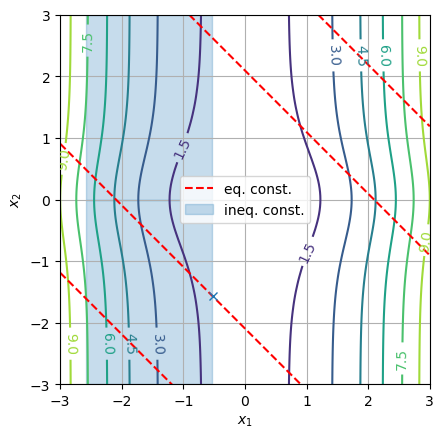

In [45]:
ax = plot_countours()
ax.plot(x[0], x[1], marker='x')
plt.show()